In [125]:
import torch
import math
import sys
import seaborn as sns
from torch.distributions import Dirichlet, Normal
from src import loss_functions as LF
from src.utils import LossFunctionWrapper

In [105]:
def compute_Gpp_basis(loss_core, B1, B2, Y, sigma = 0.02, loss_core_grad = None, loss_core_hessian = None):
    """
    Compute empirical estimate of E[(B1 y)^T g''(y) B2 y - g'(y)^T B1^T B2 y]

    Args:
        loss_core_grad: function (N x p) -> (N x p), gradient function
        loss_core_hessian: function (N x p) -> (N x p x p), Hessian function
        B1: skew-symmetric matrix (p x p)
        B2: skew-symmetric matrix (p x p)
        Y: data matrix (N x p)

    Returns:
        Scalar: empirical estimate of second derivative contribution
    """
    B1 = B1.float()
    B2 = B2.float()
    Y = Y.float()
    if Y.ndim == 1:
        Y = Y.unsqueeze(dim = 0)
        
    g = LossFunctionWrapper(loss_core, gradient_fn=loss_core_grad, hessian_fn=loss_core_hessian)

    B1Y = Y @ B1.T  # (N x p)
    B2Y = Y @ B2.T  # (N x p)

    # Hessian term: (B1 y)^T H (B2 y)
    H = g.hessian(Y, sigma, "none")        # (N x p x p)
    B2Y_exp = B2Y.unsqueeze(2)   # (N x p x 1)
    HB2Y = torch.bmm(H, B2Y_exp) # (N x p x 1)
    term1 = torch.bmm(B1Y.unsqueeze(1), HB2Y).squeeze()  # (N,)
    
    # Gradient term: g'(y)^T B1^T B2 y
    B1B2Y = Y @ (B2.T @ B1).T  # (N x p)
    gY = g.gradient(Y, sigma, "none")            # (N x p)
    term2 = (gY * B1B2Y).sum(dim=1)  # (N,)

    return (term1 - term2).mean().item()


def skew_basis(p, device = "cuda", dtype = torch.float32):
    basis = []
    for i in range(p):
        for j in range(i + 1, p):
            B = torch.zeros(p, p, device=device, dtype=dtype)
            B[i, j] = 1 / math.sqrt(2)
            B[j, i] = -1 / math.sqrt(2)
            basis.append(B)
    return torch.stack(basis)  # (d, p, p)

def construct_M_from_basis(loss_core, Y, sigma, loss_core_grad = None, loss_core_hessian = None):
    """
    Construct M matrix using basis elements B and gradient/Hessian functions.

    Args:
        g_prime: grad function (N x p) -> (N x p)
        g_double_prime: hessian function (N x p) -> (N x p x p)
        B: tensor of skew basis matrices (d x p x p)
        Y: data matrix (N x p)

    Returns:
        M: tensor of shape (d x d)
    """
    p = Y.shape[1]
    Basis = skew_basis(p, device = Y.device, dtype=Y.dtype)
    d = Basis.shape[0]
    M = torch.zeros(d, d, device=Y.device, dtype=Y.dtype)
    total = d * (d + 1) // 2  # number of (i,j) pairs where j ≥ i
    count = 0
    for i in range(d):
        for j in range(i, d):
            M[i, j] = compute_Gpp_basis(loss_core=loss_core, 
                                        B1=Basis[i], 
                                        B2=Basis[j], 
                                        Y=Y,
                                        sigma=sigma,
                                        loss_core_grad=loss_core_grad,
                                        loss_core_hessian=loss_core_hessian)
            M[j, i] = M[i, j]
            count += 1
            sys.stdout.write(f"\rCurrently at {100*count/total:.2f}%      ")
            sys.stdout.flush()
    return M



In [106]:
def mollified_relu_grad(Y, sigma=0.02, reduction = None):
    """
    Compute gradient of mollified ReLU loss w.r.t. Y.
    Y: (N x p), sigma: scalar
    Returns: (N x p) gradient matrix
    """
    if Y.ndim == 1:
        Y = Y.unsqueeze(dim = 0) # Converts shape (p, ) → (1, p)
    normal = Normal(0, 1)
    N, p = Y.shape

    # Negative term gradient (for smoothed_relu(-x_j))
    grad_neg = -normal.cdf(-Y / sigma)  # shape: (N x p)

    # Sum constraint gradient (for smoothed_relu(sum(x) - 1))
    w = Y.sum(dim=1, keepdim=True) - 1  # shape: (N x 1)
    grad_sum = normal.cdf(w / (sigma * p**0.5))  # shape: (N x 1)
    grad_sum_expanded = grad_sum.expand(-1, p)

    gradient_val = grad_neg + grad_sum_expanded
    
    if reduction == "mean":
        return gradient_val.mean(dim = 0, keepdim=True)
    else:
        return gradient_val


def mollified_relu_hess(Y, sigma=0.02, reduction = None):
    """
    Compute batched Hessian of mollified ReLU simplex loss for a batch of inputs.

    Args:
        Y (Tensor): Input tensor of shape (n, p)
        sigma (float): Smoothing parameter

    Returns:
        Tensor of shape (n, p, p): Hessians for each sample
    """
    if Y.ndim == 1:
        Y = Y.unsqueeze(dim = 0) # Converts shape (p, ) → (1, p)
    n, p = Y.shape
    device = Y.device
    dtype = Y.dtype
    normal = Normal(0, 1)

    # Diagonal term for negative entries
    term_1_vals = normal.log_prob(-Y / sigma).exp() / sigma  # (n, p)
    H_neg = torch.diag_embed(term_1_vals)  # (n, p, p)

    # Rank-one outer product for sum constraint
    sum_constraint = Y.sum(dim=1) - 1  # (n,)
    scaling = math.sqrt(p) * sigma
    term_2_vals = normal.log_prob(sum_constraint / scaling).exp() / scaling  # (n,)

    ones = torch.ones((n, p, 1), device=device, dtype=dtype)
    H_sum = term_2_vals.view(n, 1, 1) * torch.bmm(ones, ones.transpose(1, 2))  # (n, p, p)

    hessian_val = H_neg + H_sum
    
    if reduction == "mean":
        return hessian_val.mean(dim = 0, keepdim=True)
    else:
        return hessian_val

In [108]:
p = 20

alpha = torch.ones(p, p, dtype= torch.float32) + torch.eye(p, dtype= torch.float32)*2
# alpha = torch.tensor([[10, 1, 1, 1], [1, 10, 1], [1, 1, 10]], dtype= torch.float64)
# alpha = torch.tensor([[5, 1]], dtype= torch.float64)
n= 30000
K, p = alpha.shape
torch.manual_seed(5)
dir = Dirichlet(alpha)
X = dir.sample((n // K,)).transpose(0, 1).reshape(n, p)[:, :(p-1)].to("cuda")

M = construct_M_from_basis(LF.mollified_relu_simplex_core, X, 0.02, mollified_relu_grad, mollified_relu_hess)

Currently at 100.00%      tensor([0.0143, 0.0144, 0.0145, 0.0145, 0.0146, 0.0146, 0.0146, 0.0146, 0.0146,
        0.0146, 0.0147, 0.0147, 0.0147, 0.0147, 0.0147, 0.0147, 0.0148, 0.0148,
        0.0148, 0.0148, 0.0148, 0.0148, 0.0149, 0.0149, 0.0149, 0.0149, 0.0149,
        0.0149, 0.0149, 0.0150, 0.0150, 0.0150, 0.0150, 0.0150, 0.0150, 0.0150,
        0.0150, 0.0150, 0.0150, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151, 0.0151,
        0.0151, 0.0151, 0.0151, 0.0151, 0.0152, 0.0152, 0.0152, 0.0152, 0.0152,
        0.0152, 0.0152, 0.0152, 0.0152, 0.0152, 0.0152, 0.0153, 0.0153, 0.0153,
        0.0153, 0.0153, 0.0153, 0.0153, 0.0153, 0.0153, 0.0153, 0.0154, 0.0154,
        0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0154, 0.0155,
        0.0155, 0.0155, 0.0155, 0.0155, 0.0155, 0.0155, 0.0155, 0.0155, 0.0155,
        0.0155, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156, 0.0156,
        0.0156, 0.0156, 0.0156, 0.0156, 0.0157, 0.0157, 0.0157, 0.0157, 0.0157,
        0.0157

<Axes: >

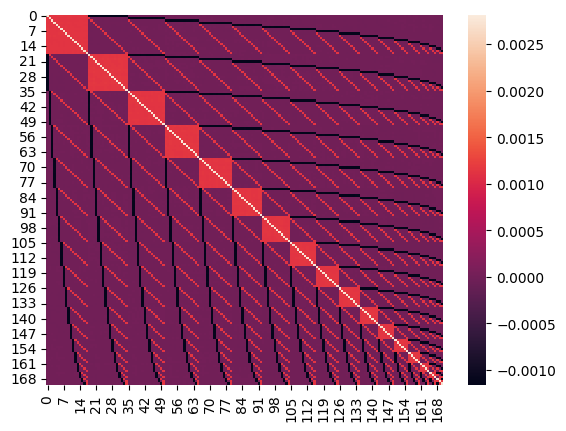

In [126]:
sns.heatmap(M.cpu().detach().numpy())

In [130]:
M_quad = construct_M_from_basis(LF.quadratic_sum_penalty_core, X, -0.02)

Currently at 100.00%      

In [132]:
torch.linalg.eigvalsh(M_quad)

tensor([-1.7175e-02, -1.7171e-02, -1.7163e-02, -1.7159e-02, -1.7154e-02,
        -1.7149e-02, -1.7146e-02, -1.7142e-02, -1.7139e-02, -1.7134e-02,
        -1.7130e-02, -1.7127e-02, -1.7119e-02, -1.7113e-02, -1.7111e-02,
        -1.7107e-02, -1.7103e-02, -1.7081e-02, -3.3627e-05, -2.7509e-05,
        -2.7028e-05, -2.6843e-05, -2.5153e-05, -2.4173e-05, -2.3269e-05,
        -2.1656e-05, -2.1558e-05, -2.1446e-05, -2.1272e-05, -2.1088e-05,
        -1.7381e-05, -1.6043e-05, -1.5562e-05, -1.5559e-05, -1.5377e-05,
        -1.4860e-05, -1.3687e-05, -1.2707e-05, -1.2406e-05, -1.1803e-05,
        -1.0190e-05, -1.0091e-05, -9.9796e-06, -9.8047e-06, -9.6217e-06,
        -9.4448e-06, -9.2589e-06, -8.7781e-06, -7.5695e-06, -7.0886e-06,
        -6.9032e-06, -6.5897e-06, -6.1085e-06, -5.9236e-06, -5.9150e-06,
        -5.6856e-06, -5.2042e-06, -5.0193e-06, -4.2330e-06, -4.0938e-06,
        -4.0726e-06, -3.9741e-06, -3.8623e-06, -3.6874e-06, -3.5917e-06,
        -3.5042e-06, -3.4926e-06, -3.4064e-06, -3.3

<Axes: >

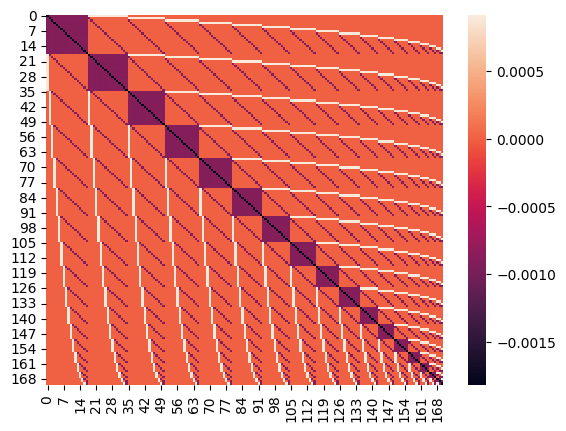

In [131]:
sns.heatmap(M_quad.cpu().detach().numpy())

Currently at 100.00%      

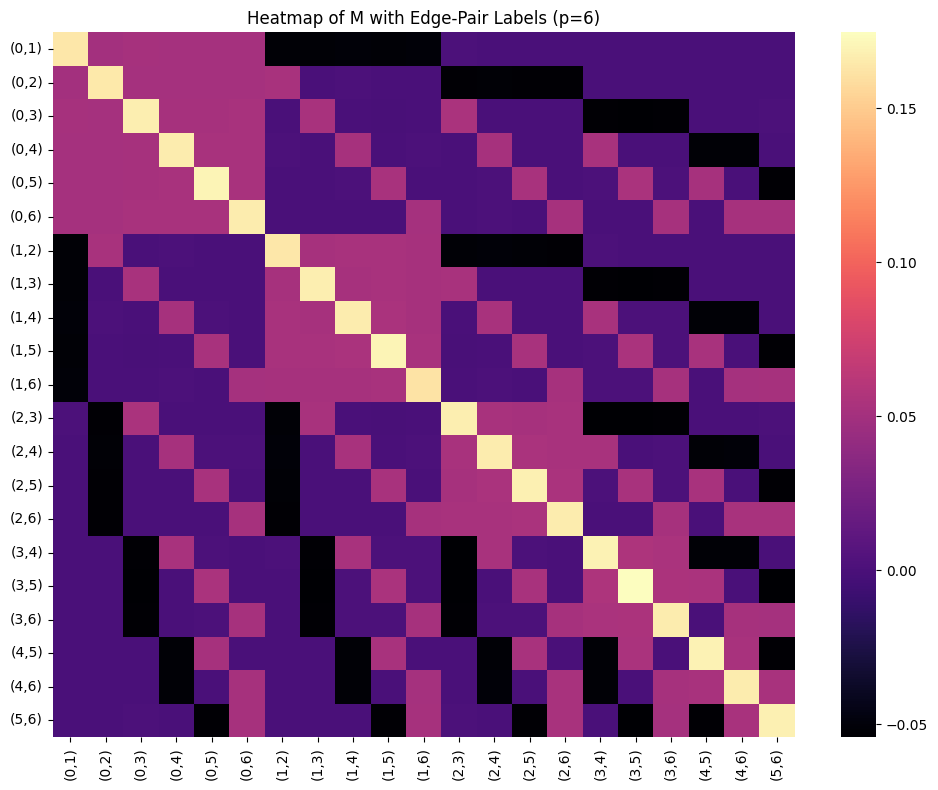

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

# Create a smaller example for p = 6
p = 7
basis_labels = []
for i in range(p):
    for j in range(i + 1, p):
        basis_labels.append(f"({i},{j})")

# d = len(basis_labels)

# Generate a synthetic M matrix with similar structure
p = 8

alpha = torch.ones(p, p, dtype= torch.float32) + torch.eye(p, dtype= torch.float32)*2
# alpha = torch.tensor([[10, 1, 1, 1], [1, 10, 1], [1, 1, 10]], dtype= torch.float64)
# alpha = torch.tensor([[5, 1]], dtype= torch.float64)
n= 28000
K, p = alpha.shape
torch.manual_seed(5)
dir = Dirichlet(alpha)
X = dir.sample((n // K,)).transpose(0, 1).reshape(n, p)[:, :(p-1)].to("cuda")

M_vis = construct_M_from_basis(LF.mollified_relu_simplex_core, X, 0.02, mollified_relu_grad, mollified_relu_hess)
M_vis = M_vis.cpu().detach().numpy()

# Plot with edge labels
plt.figure(figsize=(10, 8))
sns.heatmap(M_vis, cmap='magma', annot=False, xticklabels=basis_labels, yticklabels=basis_labels, cbar=True)
plt.title("Heatmap of M with Edge-Pair Labels (p=6)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
M - torch.diag(M)